In [1]:
from pystac_client import Client
from odc.stac import configure_rio, stac_load

Configure the bands

In [2]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16"
            }
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [3]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [4]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [51]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [13.5, 13.7, 13.7, 13.9]

# Set a start and end date
start_date = "2023-01-01"
end_date = "2025-07-01"

# Set the STAC collections
collections = ["gm_s2_rolling"]

In [52]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 29 datasets


In [56]:
crs = "EPSG:6933"
resolution = 20

ds = stac_load(
    items,
    bands=("B03","B11",),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 278MB
Dimensions:      (y: 1240, x: 966, time: 29)
Coordinates:
  * y            (y) float64 10kB 1.756e+06 1.756e+06 ... 1.732e+06 1.732e+06
  * x            (x) float64 8kB 1.303e+06 1.303e+06 ... 1.322e+06 1.322e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 232B 2023-01-01 2023-02-01 ... 2025-05-01
Data variables:
    B03          (time, y, x) float32 139MB dask.array<chunksize=(1, 1240, 966), meta=np.ndarray>
    B11          (time, y, x) float32 139MB dask.array<chunksize=(1, 1240, 966), meta=np.ndarray>

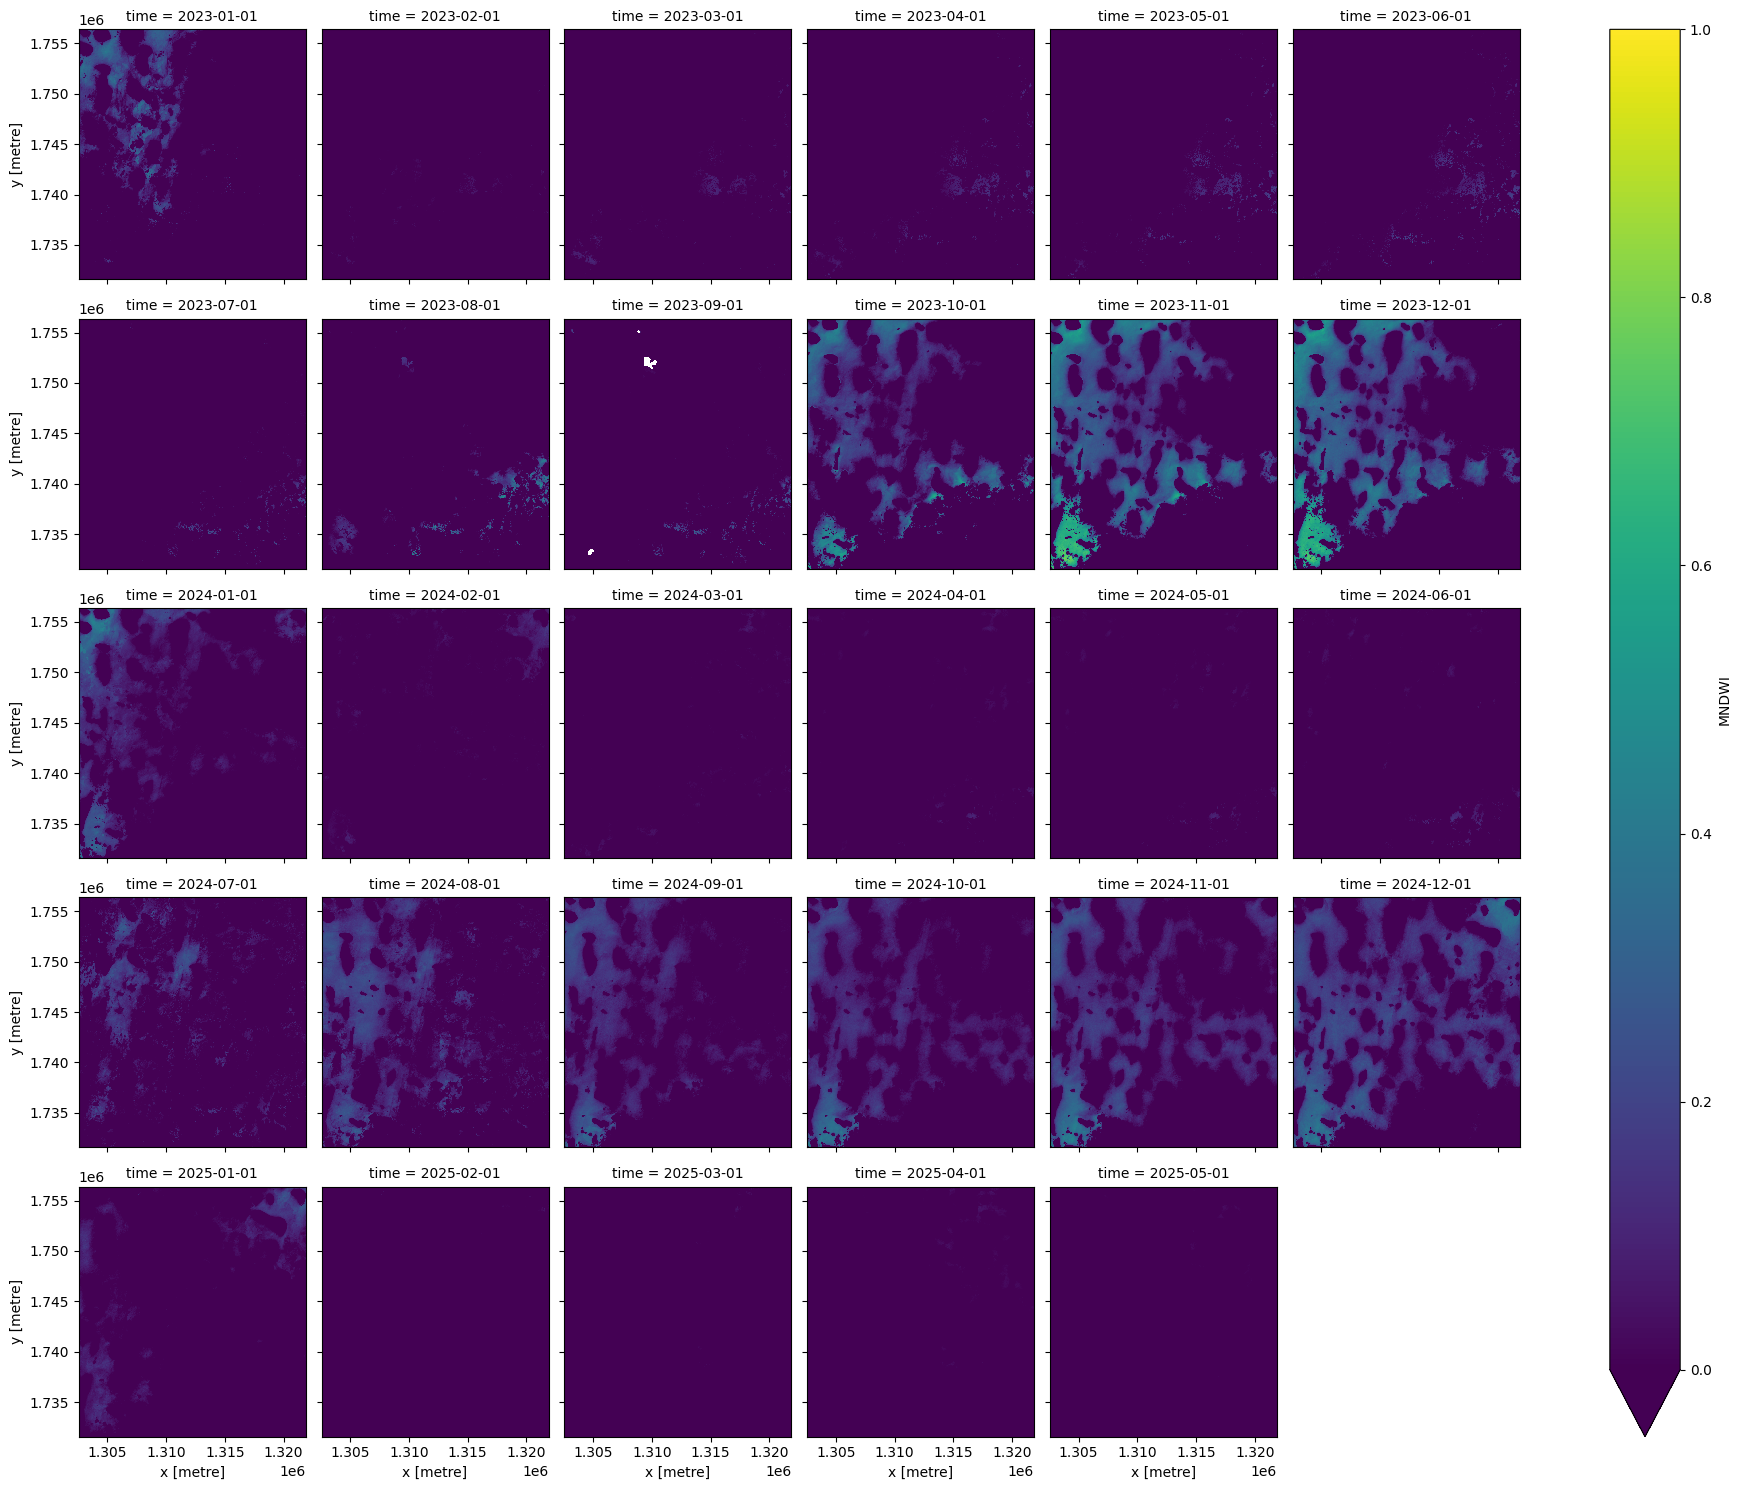

In [ ]:
ds["MNDWI"] = (ds.B03 - ds.B11) / (ds.B03 + ds.B11)


ds.MNDWI.compute().plot(col="time", col_wrap=6, vmin=-1, vmax=1)